In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
import seaborn as sns

2024-05-12 21:16:12.240206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-12 21:16:12.447453: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 21:16:13.109733: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
(train_img, train_lab), (test_img, test_lab) = mnist.load_data()

In [6]:
print(train_img.shape)
print(test_img.shape)

(60000, 28, 28)
(10000, 28, 28)


In [23]:
def dataset_construction(data, lab, unbalanced_lab_train, unbalanced_lab_test, split_prop=0.7, unbalanced_prop=1):
    """
    Split the input dataset into training and test sets with specific split proportion and unbalanced proportion.

    :param data: Original data
    :param lab: Original labels
    :param unbalanced_lab_train: List of unbalanced labels going to the training set
    :param unbalanced_lab_test: List of unbalanced labels going to the testing set
    :param split_prop: Train and test split proportion of unspecified labels
    :param unbalanced_prop: Train and test split proportion of specific labels
    :return: Training and testing sets
    """
    # Initialize lists for the custom split
    X_train, X_test, y_train, y_test = [], [], [], []

    # Process each unbalanced label for the training set
    for label in unbalanced_lab_train:
        mask_label = (lab == label)
        images_label = data[mask_label]
        labels_label = lab[mask_label]

        split_idx = int(unbalanced_prop * len(images_label))
        X_train.extend(images_label[:split_idx])
        y_train.extend(labels_label[:split_idx])
        X_test.extend(images_label[split_idx:])
        y_test.extend(labels_label[split_idx:])

    # Process each unbalanced label for the testing set
    for label in unbalanced_lab_test:
        mask_label = (lab == label)
        images_label = data[mask_label]
        labels_label = lab[mask_label]

        split_idx = int(unbalanced_prop * len(images_label))
        X_test.extend(images_label[:split_idx])
        y_test.extend(labels_label[:split_idx])
        X_train.extend(images_label[split_idx:])
        y_train.extend(labels_label[split_idx:])

    # Process the rest of the labels
    mask_rest = ~np.isin(lab, unbalanced_lab_train + unbalanced_lab_test)
    images_rest = data[mask_rest]
    labels_rest = lab[mask_rest]

    if len(images_rest) > 0:
        X_train_rest, X_test_rest, y_train_rest, y_test_rest = train_test_split(
            images_rest, labels_rest, test_size=1-split_prop, random_state=42
        )

        X_train.extend(X_train_rest)
        y_train.extend(y_train_rest)
        X_test.extend(X_test_rest)
        y_test.extend(y_test_rest)

    # Convert lists to numpy arrays
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)


    return X_train, X_test, y_train, y_test

In [3]:
def cluster(cluster_num, data, label, prop):
    '''
    use k-means to cluster data and return a set with the given size
    '''
    # Flatten data for K-means
    data_flattened = data.reshape(data.shape[0], -1)
    
    kmeans = KMeans(n_clusters=cluster_num, random_state=42).fit(data_flattened)
    clusters = kmeans.labels_

    # Create sample by sampling within each cluster
    sample = []
    sample_labels = []

    for idx in range(cluster_num):
        indices = np.where(clusters == idx)[0]
        # Sample indices
        sampled_indices = np.random.choice(indices, size=int(len(indices) * prop), replace=False)
        
        sample.append(data[sampled_indices])
        sample_labels.append(label[sampled_indices])
        
    # Concatenate all sampled data and labels
    sample = np.concatenate(sample, axis=0)
    sample_labels = np.concatenate(sample_labels, axis=0)

    return sample, sample_labels

In [14]:
def train_test(training_data, training_label, test_data, test_label, train_num, train_prop):
    loss = []
    test_reshape = test_data.reshape(test_data.shape[0], 28, 28, 1)
    test_normalize = test_reshape.astype('float32') / 255
    
    for i in range(train_num):
        X_train, _, y_train, _ = train_test_split(training_data, training_label, train_size = train_prop)
        X_train_reshape = X_train.reshape(X_train.shape[0], 28, 28, 1)
        X_train_normalize = X_train_reshape.astype('float32') / 255
        
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        model.fit(X_train_normalize, y_train, epochs=5, batch_size=64)
        test_loss, _ = model.evaluate(test_normalize, test_label)
        loss.append(test_loss)
    
    return loss

unbalanced dataset with all '1's and no '7's go to training set

In [84]:
X_a, X_b, y_a, y_b = dataset_construction(train_img, train_lab, unbalanced_lab_train = [1], unbalanced_lab_test= [7])
print(X_a.shape)

(39637, 28, 28)


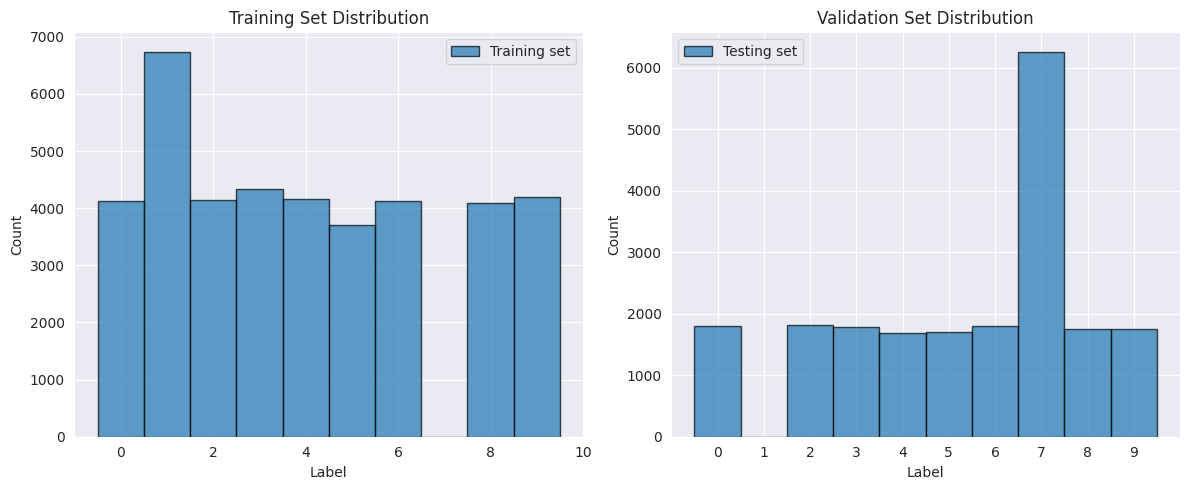

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_a, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Training set', edgecolor='black')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Distribution')
axes[0].legend()

axes[1].hist(y_b, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Testing set', edgecolor='black')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Validation Set Distribution')
axes[1].legend()

plt.xticks(range(10))
plt.tight_layout()
plt.show()

In [86]:
trad_loss = train_test(X_a, y_a, test_img, test_lab, train_num=10, train_prop=0.7)

Epoch 1/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8681 - loss: 0.4366
Epoch 2/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9840 - loss: 0.0546
Epoch 3/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9899 - loss: 0.0321
Epoch 4/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9938 - loss: 0.0196
Epoch 5/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9959 - loss: 0.0135
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8820 - loss: 2.0058
Epoch 1/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8606 - loss: 0.4524
Epoch 2/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9796 - loss: 0.0630
Epoch 3/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9899 - loss: 0.0332
Epoch 4/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9926 - loss: 0.0218
Epoch 5/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9953 - loss: 0.0148
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8829 - loss: 2.0125


In [87]:
set_size = train_img.shape[0]
X_clu, y_clu = cluster(4, train_img, train_lab, X_a.shape[0]/set_size)
print(X_clu.shape)

(39635, 28, 28)


In [90]:
losses_per_run = {i: [] for i in range(2, 11)}

for cluster_num in range(2, 11):
    print(f'number of clusters: {cluster_num}')
    X_clu, y_clu = cluster(cluster_num, train_img, train_lab, X_a.shape[0]/set_size)
    # print(X_clu.shape)
    cluster_loss = train_test(X_clu, y_clu, test_img, test_lab, train_num=10, train_prop=0.7)
    losses_per_run[cluster_num].append(cluster_loss)

number of clusters: 2
Epoch 1/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8617 - loss: 0.4492
Epoch 2/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9829 - loss: 0.0585
Epoch 3/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9891 - loss: 0.0347
Epoch 4/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9915 - loss: 0.0254
Epoch 5/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9941 - loss: 0.0171
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9755 - loss: 0.0790
Epoch 1/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8560 - loss: 0.4762
Epoch 2/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9795 - loss: 0.0720
Epoch 3/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9845 - loss: 0.0474
Epoch 4/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9915 - loss: 0.0299
Epoch 5/5
434/434 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9929 - loss: 0.0208
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 

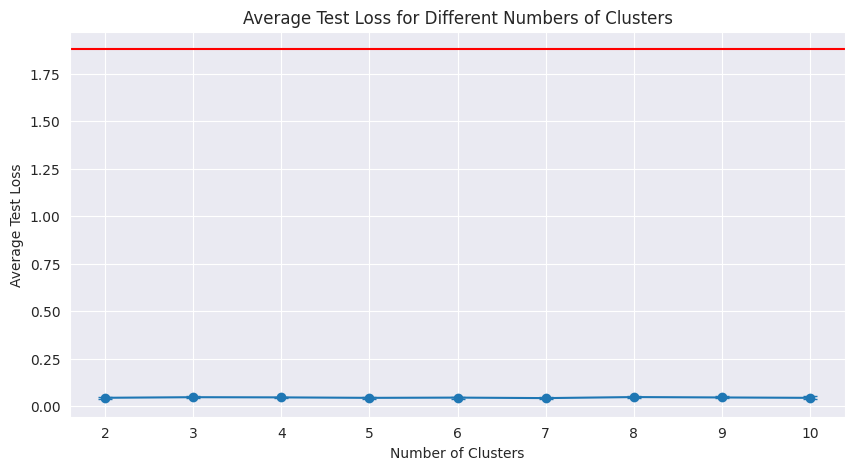

In [91]:
mean_losses = []
std_losses = []
cluster_nums = list(range(2, 11))
for num in cluster_nums:
    mean_losses.append(np.mean(losses_per_run[num]))
    std_losses.append(np.std(losses_per_run[num]))

# Plotting with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(cluster_nums, mean_losses, yerr=std_losses, fmt='-o', capsize=5, label='Clustering')
average_loss_trad = np.mean(trad_loss)
plt.axhline(y=average_loss_trad, color='r', linestyle='-', label='Traditional Model')
plt.title('Average Test Loss for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Test Loss')
plt.grid(True)
plt.show()

unbalanced dataset with 7 goes to training set and 1 goes to testing set

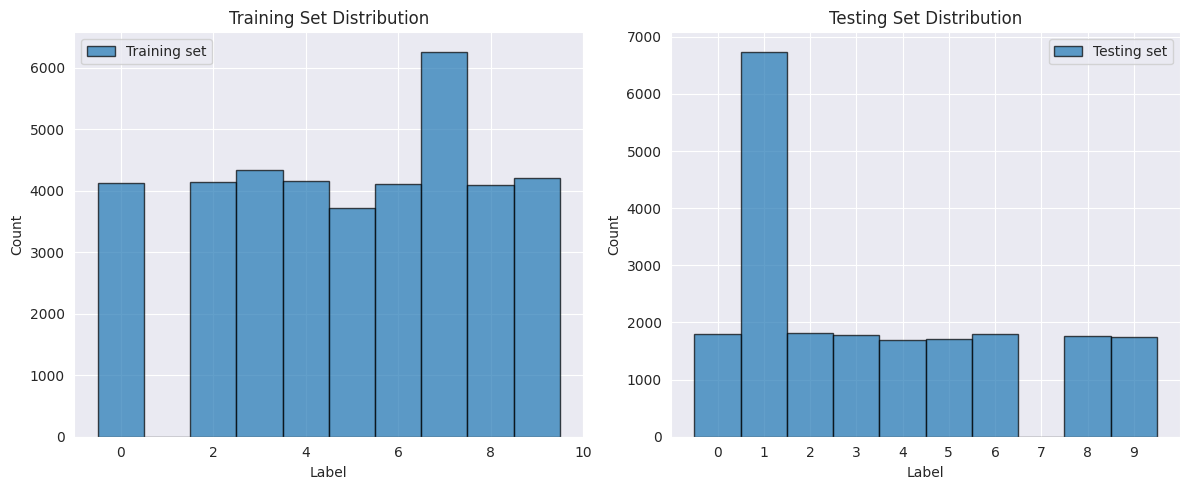

In [102]:
X_a, X_b, y_a, y_b = dataset_construction(train_img, train_lab, unbalanced_lab_train = [7], unbalanced_lab_test= [1])
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_a, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Training set', edgecolor='black')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Distribution')
axes[0].legend()

axes[1].hist(y_b, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Testing set', edgecolor='black')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Testing Set Distribution')
axes[1].legend()

plt.xticks(range(10))
plt.tight_layout()
plt.show()

In [104]:
trad_loss = train_test(X_a, y_a, test_img, test_lab, train_num=10, train_prop=0.7)

losses_per_run = {i: [] for i in range(2, 11)}

for cluster_num in range(2, 11):
    print(f'number of clusters: {cluster_num}')
    X_clu, y_clu = cluster(cluster_num, train_img, train_lab, X_a.shape[0]/set_size)
    cluster_loss = train_test(X_clu, y_clu, test_img, test_lab, train_num=5, train_prop=0.7)
    losses_per_run[cluster_num].append(cluster_loss)

Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8224 - loss: 0.5342
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9779 - loss: 0.0732
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9877 - loss: 0.0426
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9915 - loss: 0.0274
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9934 - loss: 0.0216
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8666 - loss: 1.5027
Epoch 1/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8461 - loss: 0.5028
Epoch 2/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9792 - loss: 0.0674
Epoch 3/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9882 - loss: 0.0377
Epoch 4/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9909 - loss: 0.0281
Epoch 5/5
429/429 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9931 - loss: 0.0214
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8681 - loss: 1.6159


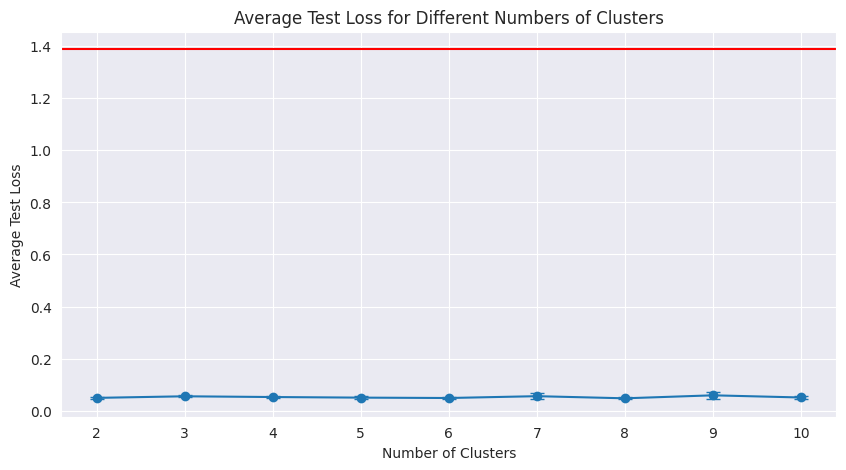

In [105]:
# Plotting with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(cluster_nums, mean_losses, yerr=std_losses, fmt='-o', capsize=5, label='Clustering')
average_loss_trad = np.mean(trad_loss)
plt.axhline(y=average_loss_trad, color='r', linestyle='-', label='Traditional Model')
plt.title('Average Test Loss for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Test Loss')
plt.grid(True)
plt.show()

unbalanced dataset with 7 goes to training set and 9 goes to testing set

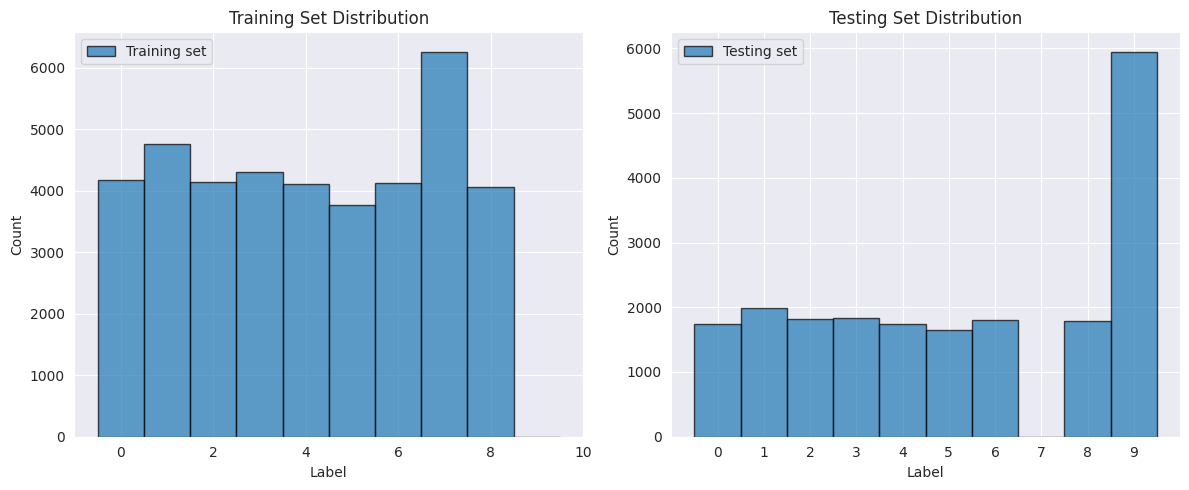

In [106]:
X_a, X_b, y_a, y_b = dataset_construction(train_img, train_lab, unbalanced_lab_train = [7], unbalanced_lab_test= [9])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_a, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Training set', edgecolor='black')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Distribution')
axes[0].legend()

axes[1].hist(y_b, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Testing set', edgecolor='black')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Testing Set Distribution')
axes[1].legend()

plt.xticks(range(10))
plt.tight_layout()
plt.show()

In [107]:
trad_loss = train_test(X_a, y_a, test_img, test_lab, train_num=10, train_prop=0.7)

Epoch 1/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8839 - loss: 0.3988
Epoch 2/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9832 - loss: 0.0570
Epoch 3/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9891 - loss: 0.0321
Epoch 4/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9929 - loss: 0.0218
Epoch 5/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9957 - loss: 0.0131
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8844 - loss: 2.0514
Epoch 1/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8682 - loss: 0.4170
Epoch 2/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9856 - loss: 0.0474
Epoch 3/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9914 - loss: 0.0269
Epoch 4/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9947 - loss: 0.0177
Epoch 5/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9961 - loss: 0.0125
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8887 - loss: 1.6761


In [108]:
losses_per_run = {i: [] for i in range(2, 11)}

for cluster_num in range(2, 11):
    print(f'number of clusters: {cluster_num}')
    X_clu, y_clu = cluster(cluster_num, train_img, train_lab, X_a.shape[0]/set_size)
    cluster_loss = train_test(X_clu, y_clu, test_img, test_lab, train_num=5, train_prop=0.7)
    losses_per_run[cluster_num].append(cluster_loss)

number of clusters: 2
Epoch 1/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8629 - loss: 0.4628
Epoch 2/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9805 - loss: 0.0645
Epoch 3/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9875 - loss: 0.0381
Epoch 4/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9923 - loss: 0.0245
Epoch 5/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9942 - loss: 0.0177
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9827 - loss: 0.0595
Epoch 1/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8533 - loss: 0.4779
Epoch 2/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9796 - loss: 0.0666
Epoch 3/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9875 - loss: 0.0390
Epoch 4/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9920 - loss: 0.0257
Epoch 5/5
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9949 - loss: 0.0173
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 

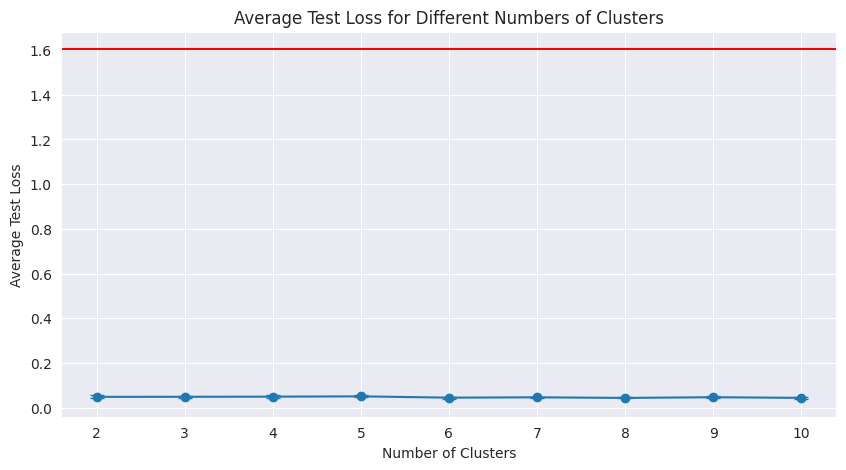

In [109]:
mean_losses = []
std_losses = []
cluster_nums = list(range(2, 11))
for num in cluster_nums:
    mean_losses.append(np.mean(losses_per_run[num]))
    std_losses.append(np.std(losses_per_run[num]))

# Plotting with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(cluster_nums, mean_losses, yerr=std_losses, fmt='-o', capsize=5, label='Clustering')
average_loss_trad = np.mean(trad_loss)
plt.axhline(y=average_loss_trad, color='r', linestyle='-', label='Traditional Model')
plt.title('Average Test Loss for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Test Loss')
plt.grid(True)
plt.show()

1,3 go to training set, 7,8 go to test set

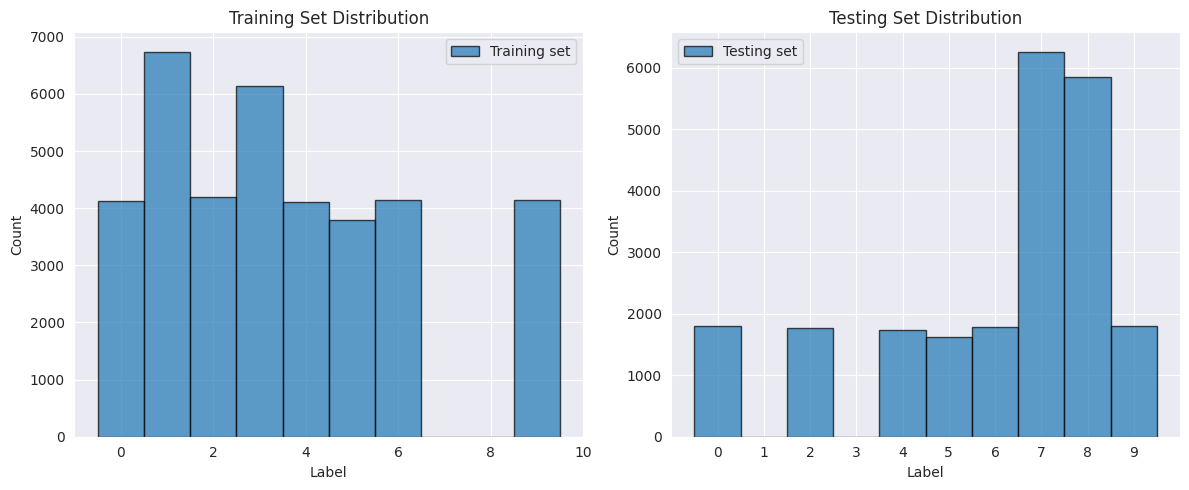

In [110]:
X_a, X_b, y_a, y_b = dataset_construction(train_img, train_lab, unbalanced_lab_train = [1,3], unbalanced_lab_test= [7,8])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_a, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Training set', edgecolor='black')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Distribution')
axes[0].legend()

axes[1].hist(y_b, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Testing set', edgecolor='black')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Testing Set Distribution')
axes[1].legend()

plt.xticks(range(10))
plt.tight_layout()
plt.show()

In [111]:
trad_loss = train_test(X_a, y_a, test_img, test_lab, train_num=10, train_prop=0.7)

losses_per_run = {i: [] for i in range(2, 11)}

for cluster_num in range(2, 11):
    print(f'number of clusters: {cluster_num}')
    X_clu, y_clu = cluster(cluster_num, train_img, train_lab, X_a.shape[0]/set_size)
    cluster_loss = train_test(X_clu, y_clu, test_img, test_lab, train_num=5, train_prop=0.7)
    losses_per_run[cluster_num].append(cluster_loss)

Epoch 1/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8762 - loss: 0.4018
Epoch 2/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9861 - loss: 0.0464
Epoch 3/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9913 - loss: 0.0264
Epoch 4/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9942 - loss: 0.0177
Epoch 5/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9961 - loss: 0.0121
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7935 - loss: 3.5322
Epoch 1/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8807 - loss: 0.3978
Epoch 2/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9877 - loss: 0.0428
Epoch 3/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9917 - loss: 0.0274
Epoch 4/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9942 - loss: 0.0189
Epoch 5/5
409/409 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9959 - loss: 0.0130
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7916 - loss: 3.5992


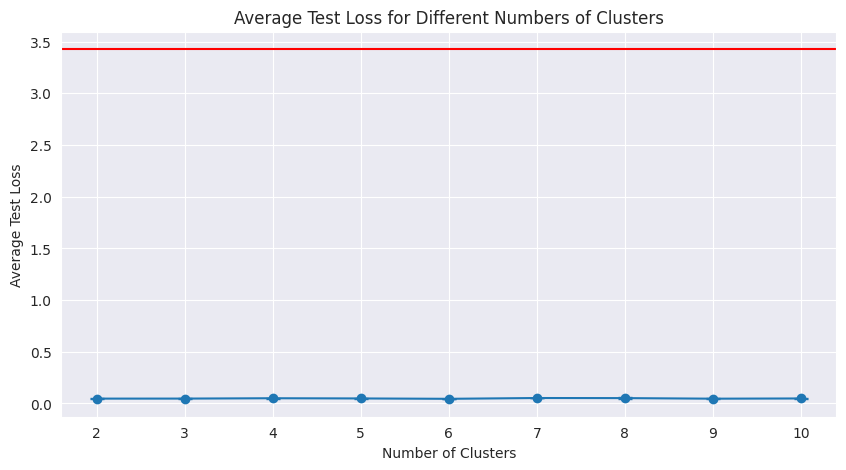

In [112]:
mean_losses = []
std_losses = []
cluster_nums = list(range(2, 11))
for num in cluster_nums:
    mean_losses.append(np.mean(losses_per_run[num]))
    std_losses.append(np.std(losses_per_run[num]))

# Plotting with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(cluster_nums, mean_losses, yerr=std_losses, fmt='-o', capsize=5, label='Clustering')
average_loss_trad = np.mean(trad_loss)
plt.axhline(y=average_loss_trad, color='r', linestyle='-', label='Traditional Model')
plt.title('Average Test Loss for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Test Loss')
plt.grid(True)
plt.show()

1,8 go to training set, 3, 7 go to test set

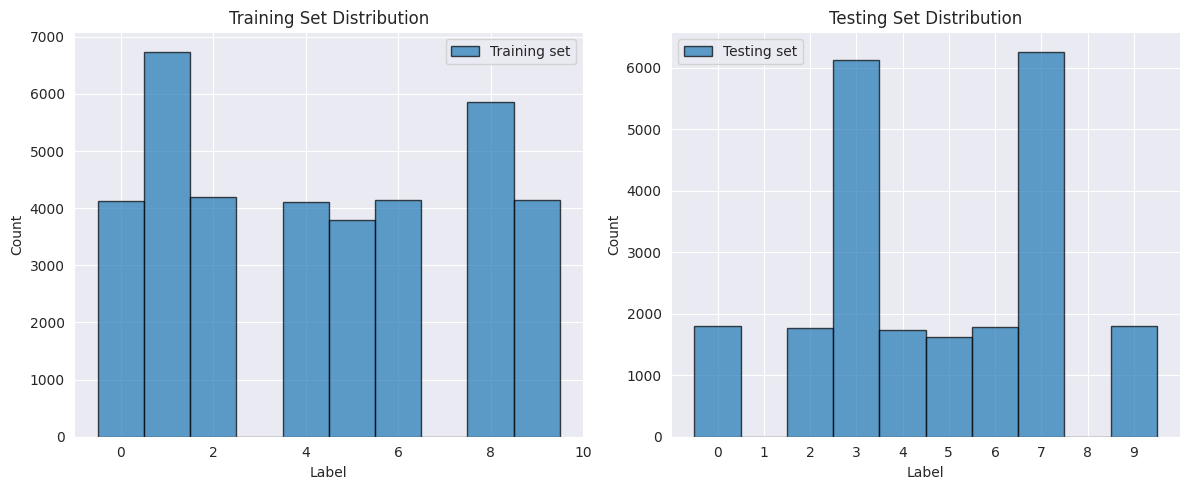

In [113]:
X_a, X_b, y_a, y_b = dataset_construction(train_img, train_lab, unbalanced_lab_train = [1,8], unbalanced_lab_test= [3, 7])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_a, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Training set', edgecolor='black')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Distribution')
axes[0].legend()

axes[1].hist(y_b, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Testing set', edgecolor='black')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Testing Set Distribution')
axes[1].legend()

plt.xticks(range(10))
plt.tight_layout()
plt.show()

In [114]:
trad_loss = train_test(X_a, y_a, test_img, test_lab, train_num=10, train_prop=0.7)

losses_per_run = {i: [] for i in range(2, 11)}

for cluster_num in range(2, 11):
    print(f'number of clusters: {cluster_num}')
    X_clu, y_clu = cluster(cluster_num, train_img, train_lab, X_a.shape[0]/set_size)
    cluster_loss = train_test(X_clu, y_clu, test_img, test_lab, train_num=5, train_prop=0.7)
    losses_per_run[cluster_num].append(cluster_loss)

Epoch 1/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8656 - loss: 0.4082
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9844 - loss: 0.0521
Epoch 3/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9901 - loss: 0.0314
Epoch 4/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9937 - loss: 0.0192
Epoch 5/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9950 - loss: 0.0147
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7876 - loss: 3.9720
Epoch 1/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8750 - loss: 0.3955
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9857 - loss: 0.0456
Epoch 3/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9901 - loss: 0.0288
Epoch 4/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9932 - loss: 0.0208
Epoch 5/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9964 - loss: 0.0123
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7813 - los

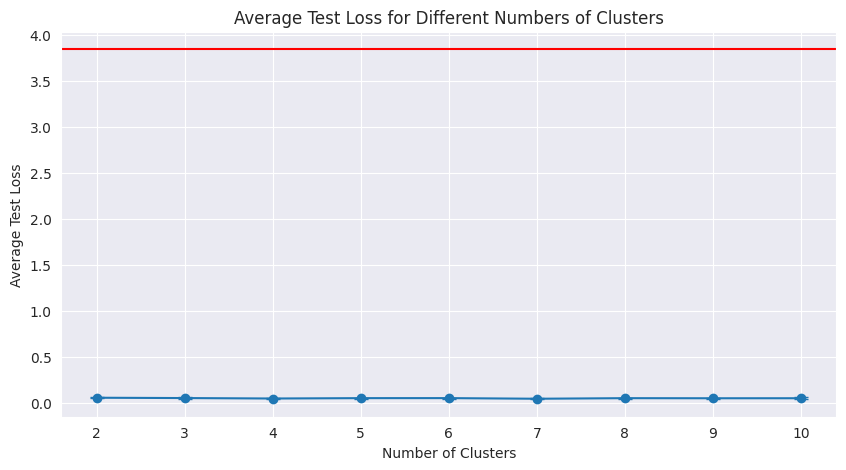

In [115]:
mean_losses = []
std_losses = []
cluster_nums = list(range(2, 11))
for num in cluster_nums:
    mean_losses.append(np.mean(losses_per_run[num]))
    std_losses.append(np.std(losses_per_run[num]))

# Plotting with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(cluster_nums, mean_losses, yerr=std_losses, fmt='-o', capsize=5, label='Clustering')
average_loss_trad = np.mean(trad_loss)
plt.axhline(y=average_loss_trad, color='r', linestyle='-', label='Traditional Model')
plt.title('Average Test Loss for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Test Loss')
plt.grid(True)
plt.show()

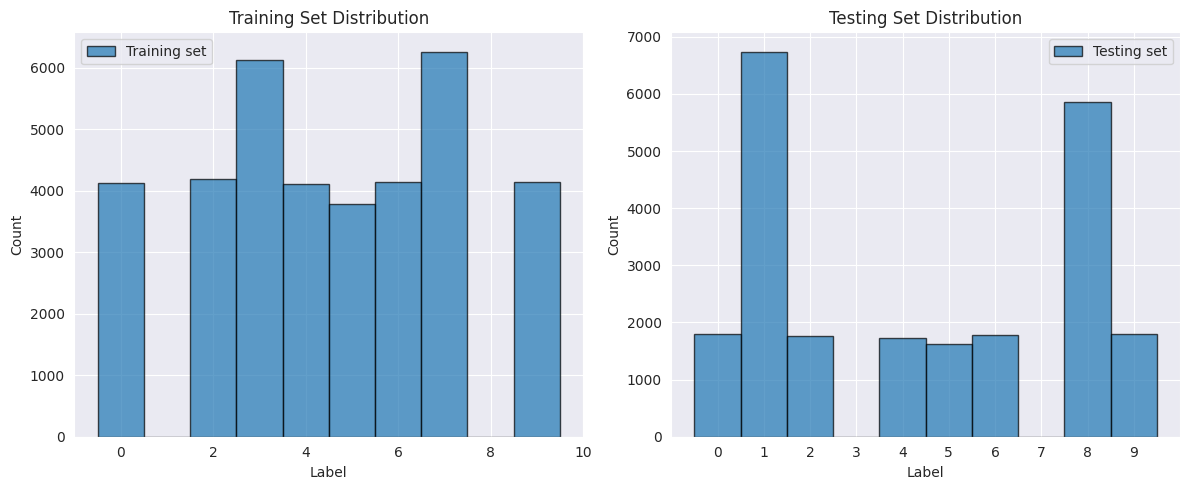

In [116]:
X_a, X_b, y_a, y_b = dataset_construction(train_img, train_lab, unbalanced_lab_train = [3,7], unbalanced_lab_test= [1, 8])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_a, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Training set', edgecolor='black')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Distribution')
axes[0].legend()

axes[1].hist(y_b, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Testing set', edgecolor='black')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Testing Set Distribution')
axes[1].legend()

plt.xticks(range(10))
plt.tight_layout()
plt.show()

Epoch 1/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8682 - loss: 0.4341
Epoch 2/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9846 - loss: 0.0506
Epoch 3/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9884 - loss: 0.0339
Epoch 4/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9922 - loss: 0.0235
Epoch 5/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9948 - loss: 0.0160
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7784 - loss: 2.4707
Epoch 1/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8609 - loss: 0.4359
Epoch 2/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9827 - loss: 0.0553
Epoch 3/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9891 - loss: 0.0333
Epoch 4/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9932 - loss: 0.0226
Epoch 5/5
404/404 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9951 - loss: 0.0165
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7760 - loss

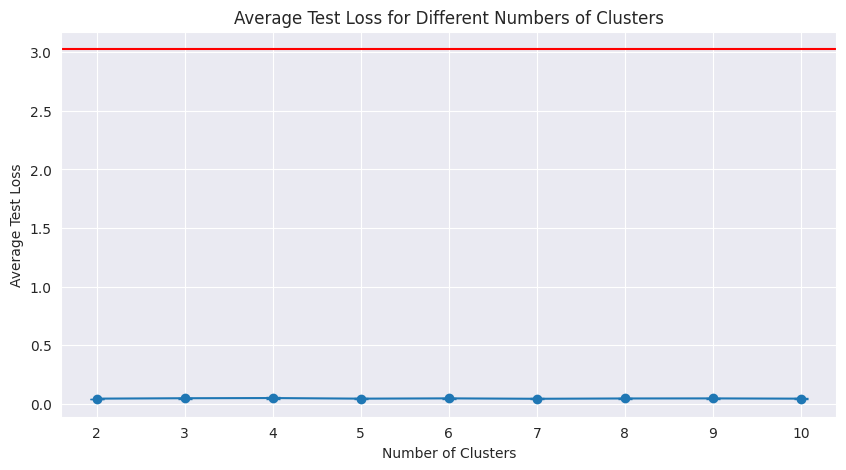

In [117]:
trad_loss = train_test(X_a, y_a, test_img, test_lab, train_num=10, train_prop=0.7)

losses_per_run = {i: [] for i in range(2, 11)}

for cluster_num in range(2, 11):
    print(f'number of clusters: {cluster_num}')
    X_clu, y_clu = cluster(cluster_num, train_img, train_lab, X_a.shape[0]/set_size)
    cluster_loss = train_test(X_clu, y_clu, test_img, test_lab, train_num=5, train_prop=0.7)
    losses_per_run[cluster_num].append(cluster_loss)
    
mean_losses = []
std_losses = []
cluster_nums = list(range(2, 11))
for num in cluster_nums:
    mean_losses.append(np.mean(losses_per_run[num]))
    std_losses.append(np.std(losses_per_run[num]))

# Plotting with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(cluster_nums, mean_losses, yerr=std_losses, fmt='-o', capsize=5, label='Clustering')
average_loss_trad = np.mean(trad_loss)
plt.axhline(y=average_loss_trad, color='r', linestyle='-', label='Traditional Model')
plt.title('Average Test Loss for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Test Loss')
plt.grid(True)
plt.show()

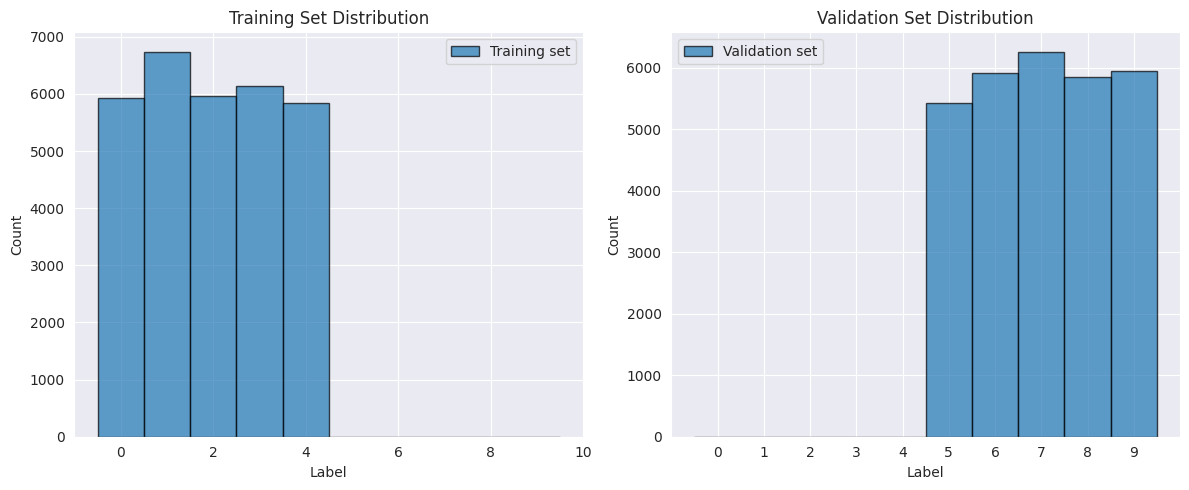

In [92]:
X_a, X_b, y_a, y_b = dataset_construction(train_img, train_lab, unbalanced_lab_train = [0, 1, 2, 3, 4], unbalanced_lab_test= [5, 6, 7, 8, 9])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_a, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Training set', edgecolor='black')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Distribution')
axes[0].legend()

axes[1].hist(y_b, bins=np.arange(0, 11)-0.5, alpha=0.7, label='Validation set', edgecolor='black')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Validation Set Distribution')
axes[1].legend()

plt.xticks(range(10))
plt.tight_layout()
plt.show()

In [93]:
X_train, _, y_train, _ = train_test_split(X_a, y_a, train_size=0.7)
X_train_reshape = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train_normalize = X_train_reshape.astype('float32') / 255

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_normalize, y_train, epochs=5, batch_size=64)


Epoch 1/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9152 - loss: 0.2746
Epoch 2/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9929 - loss: 0.0253
Epoch 3/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9950 - loss: 0.0154
Epoch 4/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9978 - loss: 0.0084
Epoch 5/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9974 - loss: 0.0080


In [94]:
test_img_reshape = test_img.reshape(test_img.shape[0], 28, 28, 1)
test_img_normalize = test_img_reshape.astype('float32') / 255

predictions = model.predict(test_img_normalize)
predicted_labels = np.argmax(predictions, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


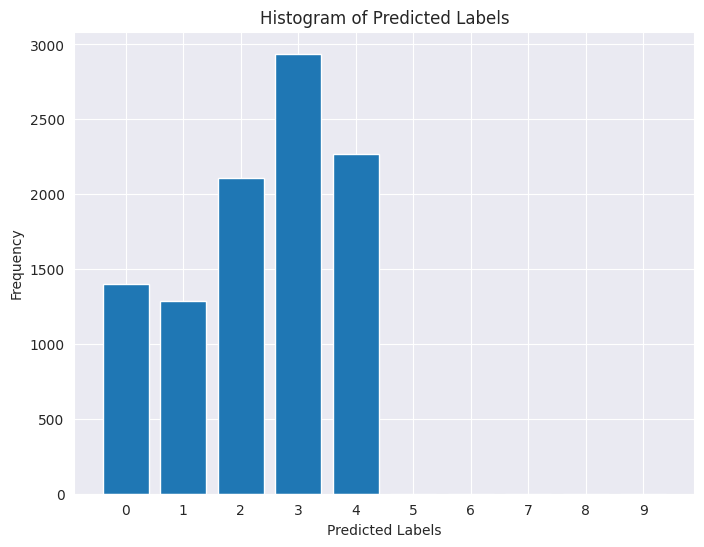

In [95]:
plt.figure(figsize=(8, 6))
plt.hist(predicted_labels, bins=range(11), align='left', rwidth=0.8)
plt.xticks(range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Labels')
plt.grid(True)
plt.show()

In [96]:
trad_loss = train_test(X_a, y_a, test_img, test_lab, train_num=10, train_prop=0.7)

Epoch 1/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8981 - loss: 0.3210
Epoch 2/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9898 - loss: 0.0340
Epoch 3/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9950 - loss: 0.0156
Epoch 4/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9962 - loss: 0.0102
Epoch 5/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9980 - loss: 0.0063
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5174 - loss: 7.3153
Epoch 1/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9202 - loss: 0.2852
Epoch 2/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9925 - loss: 0.0273
Epoch 3/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9953 - loss: 0.0154
Epoch 4/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9977 - loss: 0.0092
Epoch 5/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9979 - loss: 0.0074
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5167 - loss: 6.5738


In [97]:
losses_per_run = {i: [] for i in range(2, 11)}

for cluster_num in range(2, 11):
    print(f'number of clusters: {cluster_num}')
    X_clu, y_clu = cluster(cluster_num, train_img, train_lab, X_a.shape[0]/set_size)
    cluster_loss = train_test(X_clu, y_clu, test_img, test_lab, train_num=5, train_prop=0.7)
    losses_per_run[cluster_num].append(cluster_loss)

number of clusters: 2
Epoch 1/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8288 - loss: 0.5533
Epoch 2/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9766 - loss: 0.0809
Epoch 3/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9860 - loss: 0.0469
Epoch 4/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9895 - loss: 0.0350
Epoch 5/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9931 - loss: 0.0216
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9803 - loss: 0.0702
Epoch 1/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8411 - loss: 0.5390
Epoch 2/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9787 - loss: 0.0738
Epoch 3/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9874 - loss: 0.0377
Epoch 4/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9924 - loss: 0.0275
Epoch 5/5
335/335 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9940 - loss: 0.0186
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 

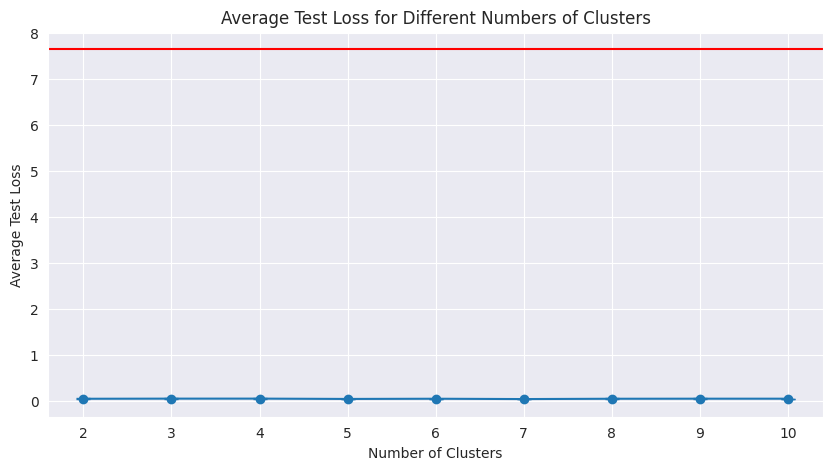

In [98]:
mean_losses = []
std_losses = []
cluster_nums = list(range(2, 11))
for num in cluster_nums:
    mean_losses.append(np.mean(losses_per_run[num]))
    std_losses.append(np.std(losses_per_run[num]))

# Plotting with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(cluster_nums, mean_losses, yerr=std_losses, fmt='-o', capsize=5, label='Clustering')
average_loss_trad = np.mean(trad_loss)
plt.axhline(y=average_loss_trad, color='r', linestyle='-', label='Traditional Model')
plt.title('Average Test Loss for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Test Loss')
plt.grid(True)
plt.show()

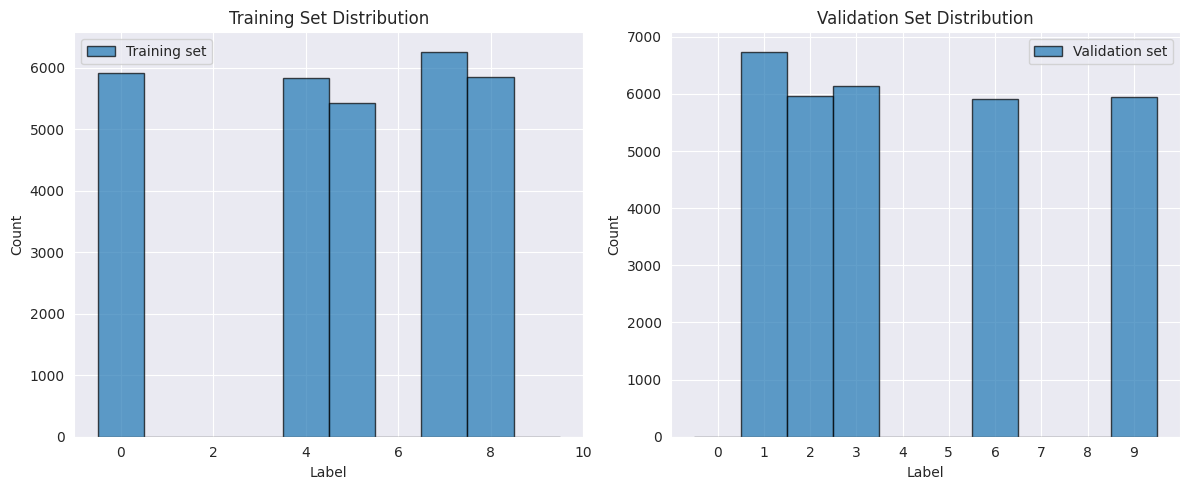

In [99]:
X_a, X_b, y_a, y_b = dataset_construction(train_img, train_lab, unbalanced_lab_train=[0, 4, 5, 7, 8],
                                          unbalanced_lab_test=[1, 2, 3, 6, 9])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(y_a, bins=np.arange(0, 11) - 0.5, alpha=0.7, label='Training set', edgecolor='black')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Distribution')
axes[0].legend()

axes[1].hist(y_b, bins=np.arange(0, 11) - 0.5, alpha=0.7, label='Validation set', edgecolor='black')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title('Validation Set Distribution')
axes[1].legend()

plt.xticks(range(10))
plt.tight_layout()
plt.show()

In [100]:
trad_loss = train_test(X_a, y_a, test_img, test_lab, train_num=10, train_prop=0.7)

losses_per_run = {i: [] for i in range(2, 11)}

for cluster_num in range(2, 11):
    print(f'number of clusters: {cluster_num}')
    X_clu, y_clu = cluster(cluster_num, train_img, train_lab, X_a.shape[0]/set_size)
    cluster_loss = train_test(X_clu, y_clu, test_img, test_lab, train_num=5, train_prop=0.7)
    losses_per_run[cluster_num].append(cluster_loss)

Epoch 1/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8858 - loss: 0.3403
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9870 - loss: 0.0364
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9935 - loss: 0.0204
Epoch 4/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9958 - loss: 0.0127
Epoch 5/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9967 - loss: 0.0098
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4824 - loss: 8.7514
Epoch 1/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8971 - loss: 0.3301
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9893 - loss: 0.0330
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9925 - loss: 0.0221
Epoch 4/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9961 - loss: 0.0129
Epoch 5/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9970 - loss: 0.0106
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4790 - loss: 9.1005


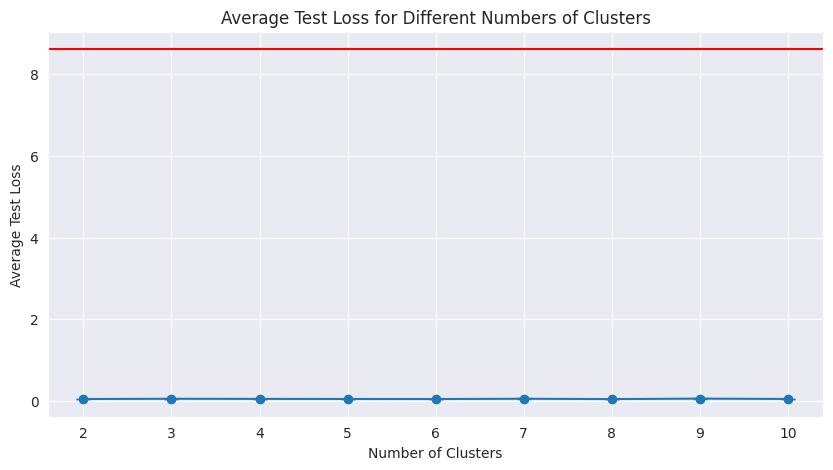

In [101]:
mean_losses = []
std_losses = []
cluster_nums = list(range(2, 11))
for num in cluster_nums:
    mean_losses.append(np.mean(losses_per_run[num]))
    std_losses.append(np.std(losses_per_run[num]))

# Plotting with error bars
plt.figure(figsize=(10, 5))
plt.errorbar(cluster_nums, mean_losses, yerr=std_losses, fmt='-o', capsize=5, label='Clustering')
average_loss_trad = np.mean(trad_loss)
plt.axhline(y=average_loss_trad, color='r', linestyle='-', label='Traditional Model')
plt.title('Average Test Loss for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Test Loss')
plt.grid(True)
plt.show()